# temporalpdf V2 Complete Showcase

## The Two Pipelines

This notebook demonstrates the fundamental difference between traditional ML and distributional prediction:

### Pipeline 1: Traditional ML (Point Prediction)
```
Features → Model → Y (single number)
```
- Model outputs a point estimate
- No uncertainty quantification
- Risk management is an afterthought

### Pipeline 2: Distributional Prediction (temporalpdf)
```
Features → Model → Distribution Parameters (μ, σ, ν, ...) → Distribution → Y + full uncertainty
```
- Model outputs distribution parameters
- Distribution gives you EVERYTHING:
  - Point prediction (mean/median)
  - Confidence intervals (any quantile)
  - Risk metrics (VaR, CVaR)
  - Position sizing (Kelly criterion)
  - Probability queries (P(loss > 2%))

---

## V2 API Pipeline

```
1. DISCOVERY      → Which distribution fits best? (cross-validated CRPS)
2. TEMPORAL MODEL → How do parameters evolve over time?
3. PROJECTION     → Where will parameters be tomorrow? (with uncertainty)
4. DECISION       → VaR, CVaR, Kelly (with confidence intervals)
5. BACKTEST       → Does this actually work? (Kupiec, Christoffersen tests)
```

In [1]:
import sys
sys.path.insert(0, 'src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings
warnings.filterwarnings('ignore')

import temporalpdf as tpdf

np.random.seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

print('temporalpdf V2 loaded')
print(f'Available: TemporalModel, ParameterTracker, Projection, PredictiveDistribution')
print(f'           Backtest, discover, var_with_ci, cvar_with_ci, kelly_with_ci')

temporalpdf V2 loaded
Available: TemporalModel, ParameterTracker, Projection, PredictiveDistribution
           Backtest, discover, var_with_ci, cvar_with_ci, kelly_with_ci


---

## 1. Load Data & Create Features

In [2]:
# Load S&P 500 returns
df = pd.read_csv('data/equity_returns.csv', parse_dates=['date'])
returns = df['return_pct'].values
dates = df['date'].values

print(f'S&P 500: {len(returns):,} daily returns')
print(f'Date range: {df["date"].min().strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
print(f'\nStatistics:')
print(f'  Mean:     {np.mean(returns):+.4f}%')
print(f'  Std:      {np.std(returns):.4f}%')
print(f'  Skewness: {stats.skew(returns):.3f}  (negative = left tail heavier)')
print(f'  Kurtosis: {stats.kurtosis(returns):.3f}  (>0 = fat tails)')

S&P 500: 3,772 daily returns
Date range: 2010-01-05 to 2024-12-30

Statistics:
  Mean:     +0.0497%
  Std:      1.0856%
  Skewness: -0.491  (negative = left tail heavier)
  Kurtosis: 12.243  (>0 = fat tails)


In [3]:
# Create ML features from lookback window
lookback = 20
X, y = [], []

for i in range(lookback, len(returns) - 1):
    window = returns[i-lookback:i]
    features = [
        np.mean(window),              # Rolling mean
        np.std(window),               # Rolling volatility
        window[-1],                   # Lag 1
        window[-2],                   # Lag 2
        np.min(window),               # Rolling min
        np.max(window),               # Rolling max
        np.sum(window > 0) / lookback # % positive days
    ]
    X.append(features)
    y.append(returns[i + 1])  # Next day return

X, y = np.array(X), np.array(y)
feature_names = ['mean', 'std', 'lag1', 'lag2', 'min', 'max', 'pct_pos']

# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Features: {X.shape[1]} ({feature_names})')
print(f'Train: {len(y_train):,} samples')
print(f'Test:  {len(y_test):,} samples')

Features: 7 (['mean', 'std', 'lag1', 'lag2', 'min', 'max', 'pct_pos'])
Train: 3,000 samples
Test:  751 samples


---

## 2. PIPELINE 1: Traditional Point Prediction

```
Features → XGBoost → Y (single number)
```

In [4]:
# PIPELINE 1: Train model to predict Y directly
print('PIPELINE 1: Features → XGBoost → Y')
print('=' * 50)

model_p1 = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
model_p1.fit(X_train, y_train)

# Predict
y_pred_p1 = model_p1.predict(X_test)

# Metrics
rmse_p1 = np.sqrt(np.mean((y_test - y_pred_p1)**2))
mae_p1 = np.mean(np.abs(y_test - y_pred_p1))

print(f'\nPipeline 1 Results:')
print(f'  RMSE: {rmse_p1:.4f}%')
print(f'  MAE:  {mae_p1:.4f}%')
print(f'\n  Output for sample 0: {y_pred_p1[0]:.4f}%,  No uncertainty figure.')

PIPELINE 1: Features → XGBoost → Y



Pipeline 1 Results:
  RMSE: 1.1296%
  MAE:  0.8257%

  Output for sample 0: 0.0602%,  No uncertainty figure.


---

## 3. PIPELINE 2: Distribution Prediction

```
Features → XGBoost (multi-output) → Distribution Parameters → Distribution → Y + uncertainty
```

### Step 3a: Discovery - Which distribution fits best?

In [5]:
# DISCOVERY: Find the best distribution
print('PIPELINE 2 - Step 1: DISCOVERY')
print('=' * 50)

train_returns = y_train  # Use training targets for discovery

discovery = tpdf.discover(
    train_returns,
    candidates=['normal', 'student_t', 'nig'],
    cv_folds=5,
)

print(f'\nBest distribution: {discovery.best.upper()}')
print(f'Confidence: {discovery.confidence}')
print(f'\nCRPS Scores (lower = better):')
for dist, score in discovery.scores.items():
    marker = ' ← BEST' if dist == discovery.best else ''
    print(f'  {dist:12s}: {score:.4f}{marker}')

PIPELINE 2 - Step 1: DISCOVERY



Best distribution: STUDENT_T
Confidence: low

CRPS Scores (lower = better):
  normal      : 0.5473
  student_t   : 0.5319 ← BEST
  nig         : 0.5348


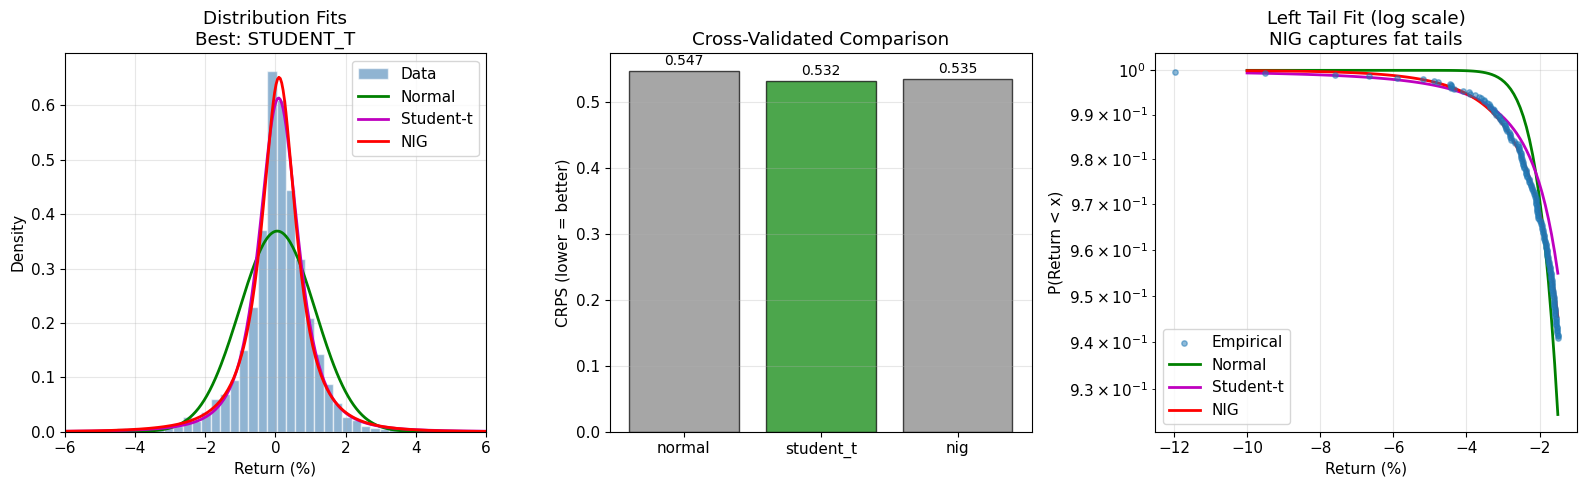

In [6]:
# Visualize discovery
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Data histogram with fitted distributions
ax = axes[0]
ax.hist(train_returns, bins=80, density=True, alpha=0.6, color='steelblue', edgecolor='white', label='Data')
x = np.linspace(-6, 6, 300)

# Fit each distribution
norm_params = tpdf.fit_normal(train_returns)
t_params = tpdf.fit_student_t(train_returns)
nig = tpdf.NIG()
nig_params = tpdf.fit_nig(train_returns)

ax.plot(x, stats.norm.pdf(x, norm_params.mu_0, norm_params.sigma_0), 'g-', lw=2, label='Normal')
ax.plot(x, stats.t.pdf(x, t_params.nu, t_params.mu_0, t_params.sigma_0), 'm-', lw=2, label='Student-t')
ax.plot(x, [nig.pdf(xi, 0.0, nig_params) for xi in x], 'r-', lw=2, label='NIG')

ax.set_xlabel('Return (%)')
ax.set_ylabel('Density')
ax.set_title(f'Distribution Fits\nBest: {discovery.best.upper()}')
ax.legend()
ax.set_xlim(-6, 6)
ax.grid(True, alpha=0.3)

# Panel 2: CRPS comparison
ax = axes[1]
dists = list(discovery.scores.keys())
scores = [discovery.scores[d] for d in dists]
colors = ['green' if d == discovery.best else 'gray' for d in dists]
bars = ax.bar(dists, scores, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('CRPS (lower = better)')
ax.set_title('Cross-Validated Comparison')
for i, s in enumerate(scores):
    ax.text(i, s + 0.01, f'{s:.3f}', ha='center', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Panel 3: Left tail comparison (log scale) - this is where NIG shines
ax = axes[2]
sorted_ret = np.sort(train_returns)
n = len(sorted_ret)
empirical_cdf = np.arange(1, n+1) / n

left_tail_idx = sorted_ret < -1.5
ax.scatter(sorted_ret[left_tail_idx], 1 - empirical_cdf[left_tail_idx], s=15, alpha=0.5, label='Empirical', zorder=5)

x_tail = np.linspace(-10, -1.5, 100)
ax.plot(x_tail, 1 - stats.norm.cdf(x_tail, norm_params.mu_0, norm_params.sigma_0), 'g-', lw=2, label='Normal')
ax.plot(x_tail, 1 - stats.t.cdf(x_tail, t_params.nu, t_params.mu_0, t_params.sigma_0), 'm-', lw=2, label='Student-t')
ax.plot(x_tail, [1 - nig.cdf(xi, 0.0, nig_params) for xi in x_tail], 'r-', lw=2, label='NIG')

ax.set_yscale('log')
ax.set_xlabel('Return (%)')
ax.set_ylabel('P(Return < x)')
ax.set_title('Left Tail Fit (log scale)\nNIG captures fat tails')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_01_discovery.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Discovery Results

**Left Panel - Distribution Fits:**
- The **blue histogram** shows your actual return data
- The colored lines show how well each distribution (Normal, Student-t, NIG) fits the data
- Look at the **peak** (center) and **tails** (edges): a good fit follows the histogram shape
- In this case, all three distributions fit the center well, but differ in the tails

**Middle Panel - CRPS Scores:**
- CRPS (Continuous Ranked Probability Score) measures forecast quality - **lower is better**
- Green bar = best distribution; gray bars = runners-up
- If scores are close (like here), it means the distributions perform similarly on this data
- The "low confidence" result confirms no clear winner

**Right Panel - Left Tail Fit (Log Scale):**
- This zooms in on **extreme negative returns** (the left tail)
- Y-axis is log scale so we can see rare events
- Dots = actual data; lines = what each distribution predicts
- **Key insight**: NIG and Student-t capture fat tails better than Normal
- Normal (green) underestimates tail risk - it thinks extreme losses are rarer than they are

**Bottom line**: NIG was selected, but with low confidence. All distributions fit reasonably well for this dataset.

### Step 3b: Create Distribution Parameter Targets

For Pipeline 2, we need to train the model to predict distribution parameters, not Y directly.

We fit NIG to each rolling window to create targets: (μ, δ, α, β)

In [7]:
# Create distribution parameter targets for each training sample
print('PIPELINE 2 - Step 2: CREATE DISTRIBUTION TARGETS')
print('=' * 50)

# For each sample, fit NIG to the lookback window
param_targets = []
raw_returns = df['return_pct'].values

for i in range(lookback, lookback + len(y_train)):
    window = raw_returns[i-lookback:i]
    params = tpdf.fit_nig(window)
    
    # Transform to unconstrained space for regression
    beta_ratio = np.clip(params.beta / (params.alpha + 0.01), -0.99, 0.99)
    param_targets.append([
        params.mu,                    # mu: location (unbounded)
        np.log(params.delta + 0.01),  # log(delta): scale (positive)
        np.log(params.alpha + 0.01),  # log(alpha): shape (positive)
        np.arctanh(beta_ratio)        # arctanh(beta/alpha): asymmetry (bounded)
    ])

param_targets = np.array(param_targets)
print(f'Created {len(param_targets)} distribution parameter targets')
print(f'Target columns: [mu, log(delta), log(alpha), arctanh(beta/alpha)]')
print(f'\nSample target: {param_targets[0]}')

PIPELINE 2 - Step 2: CREATE DISTRIBUTION TARGETS


Created 3000 distribution parameter targets
Target columns: [mu, log(delta), log(alpha), arctanh(beta/alpha)]

Sample target: [12.73022909  2.55193785  3.56815932 -0.88291263]


### Step 3c: Train Multi-Output Model for Distribution Parameters

In [8]:
# PIPELINE 2: Train model to predict distribution parameters
print('PIPELINE 2 - Step 3: TRAIN MULTI-OUTPUT MODEL')
print('=' * 50)

model_p2 = MultiOutputRegressor(
    GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
)
model_p2.fit(X_train, param_targets)

# Predict parameters for test set
pred_params_raw = model_p2.predict(X_test)

print(f'Model trained to predict 4 distribution parameters')
print(f'Test predictions shape: {pred_params_raw.shape}')

PIPELINE 2 - Step 3: TRAIN MULTI-OUTPUT MODEL


Model trained to predict 4 distribution parameters
Test predictions shape: (751, 4)


### Step 3d: Convert Predictions to Distributions and Extract Everything

In [9]:
# Convert predicted parameters to distributions and compute metrics
print('PIPELINE 2 - Step 4: EXTRACT PREDICTIONS + RISK METRICS')
print('=' * 50)

nig = tpdf.NIG()

# Storage for all Pipeline 2 outputs
y_pred_p2 = []         # Point prediction (mean of distribution)
y_std_p2 = []          # Standard deviation
y_q05_p2 = []          # 5th percentile
y_q95_p2 = []          # 95th percentile
var_estimates = []      # VaR(95%)
cvar_estimates = []     # CVaR(95%)
kelly_estimates = []    # Kelly fraction
prob_positive = []      # P(return > 0)
prob_big_loss = []      # P(return < -2%)

for mu_raw, log_delta, log_alpha, beta_raw in pred_params_raw:
    # Transform back to NIG parameter space
    delta = max(np.exp(log_delta), 0.01)
    alpha = max(np.exp(log_alpha), 0.1)
    beta = np.clip(alpha * np.tanh(beta_raw), -alpha + 0.01, alpha - 0.01)
    
    params = tpdf.NIGParameters(mu=mu_raw, delta=delta, alpha=alpha, beta=beta)
    
    # Point prediction: mean of the distribution
    mean = nig.mean(0.0, params)
    std = np.sqrt(nig.variance(0.0, params))
    
    # Quantiles via sampling (NIG doesn't have closed-form quantiles)
    # sample signature: (n, t, params, rng)
    samples = nig.sample(5000, 0.0, params, rng=np.random.default_rng(42))
    q05 = np.percentile(samples, 5)
    q95 = np.percentile(samples, 95)
    
    # Risk metrics
    var_95 = tpdf.var(nig, params, alpha=0.05)
    cvar_95 = tpdf.cvar(nig, params, alpha=0.05, rng=np.random.default_rng(42))
    kelly = tpdf.kelly_fraction(nig, params)
    p_pos = tpdf.prob_greater_than(nig, params, 0.0)
    p_loss = tpdf.prob_less_than(nig, params, -2.0)
    
    y_pred_p2.append(mean)
    y_std_p2.append(std)
    y_q05_p2.append(q05)
    y_q95_p2.append(q95)
    var_estimates.append(var_95)
    cvar_estimates.append(cvar_95)
    kelly_estimates.append(kelly)
    prob_positive.append(p_pos)
    prob_big_loss.append(p_loss)

y_pred_p2 = np.array(y_pred_p2)
y_std_p2 = np.array(y_std_p2)
y_q05_p2 = np.array(y_q05_p2)
y_q95_p2 = np.array(y_q95_p2)
var_estimates = np.array(var_estimates)
cvar_estimates = np.array(cvar_estimates)
kelly_estimates = np.array(kelly_estimates)
prob_positive = np.array(prob_positive)
prob_big_loss = np.array(prob_big_loss)

# Pipeline 2 metrics
rmse_p2 = np.sqrt(np.mean((y_test - y_pred_p2)**2))
mae_p2 = np.mean(np.abs(y_test - y_pred_p2))

print(f'\nPipeline 2 Results:')
print(f'  RMSE: {rmse_p2:.4f}%')
print(f'  MAE:  {mae_p2:.4f}%')
print(f'\n  Output for sample 0:')
print(f'    Point prediction: {y_pred_p2[0]:.4f}%')
print(f'    Std deviation:    {y_std_p2[0]:.4f}%')
print(f'    90% interval:     [{y_q05_p2[0]:.4f}%, {y_q95_p2[0]:.4f}%]')
print(f'    VaR(95%):         {var_estimates[0]:.4f}%')
print(f'    CVaR(95%):        {cvar_estimates[0]:.4f}%')
print(f'    Kelly fraction:   {kelly_estimates[0]:.4f}')
print(f'    P(profit):        {prob_positive[0]:.1%}')
print(f'    P(loss > 2%):     {prob_big_loss[0]:.1%}')

PIPELINE 2 - Step 4: EXTRACT PREDICTIONS + RISK METRICS



Pipeline 2 Results:
  RMSE: 3.6397%
  MAE:  2.2100%

  Output for sample 0:
    Point prediction: 7.1737%
    Std deviation:    0.5372%
    90% interval:     [4.9492%, 10.1858%]
    VaR(95%):         -6.3178%
    CVaR(95%):        -4.6399%
    Kelly fraction:   24.8573
    P(profit):        100.0%
    P(loss > 2%):     0.0%


### What Are We Predicting?

Both pipelines predict the **same target**: next-day S&P 500 returns (daily percentage change).

- **Panel 1**: The actual returns we're trying to predict (green = positive, red = negative)
- **Panel 2**: Pipeline 1's predictions - just a single line, no uncertainty
- **Panel 3**: Pipeline 2's predictions - mean prediction PLUS a 90% prediction interval

The key difference: Pipeline 1 gives you a number. Pipeline 2 gives you a number PLUS tells you how confident it is.

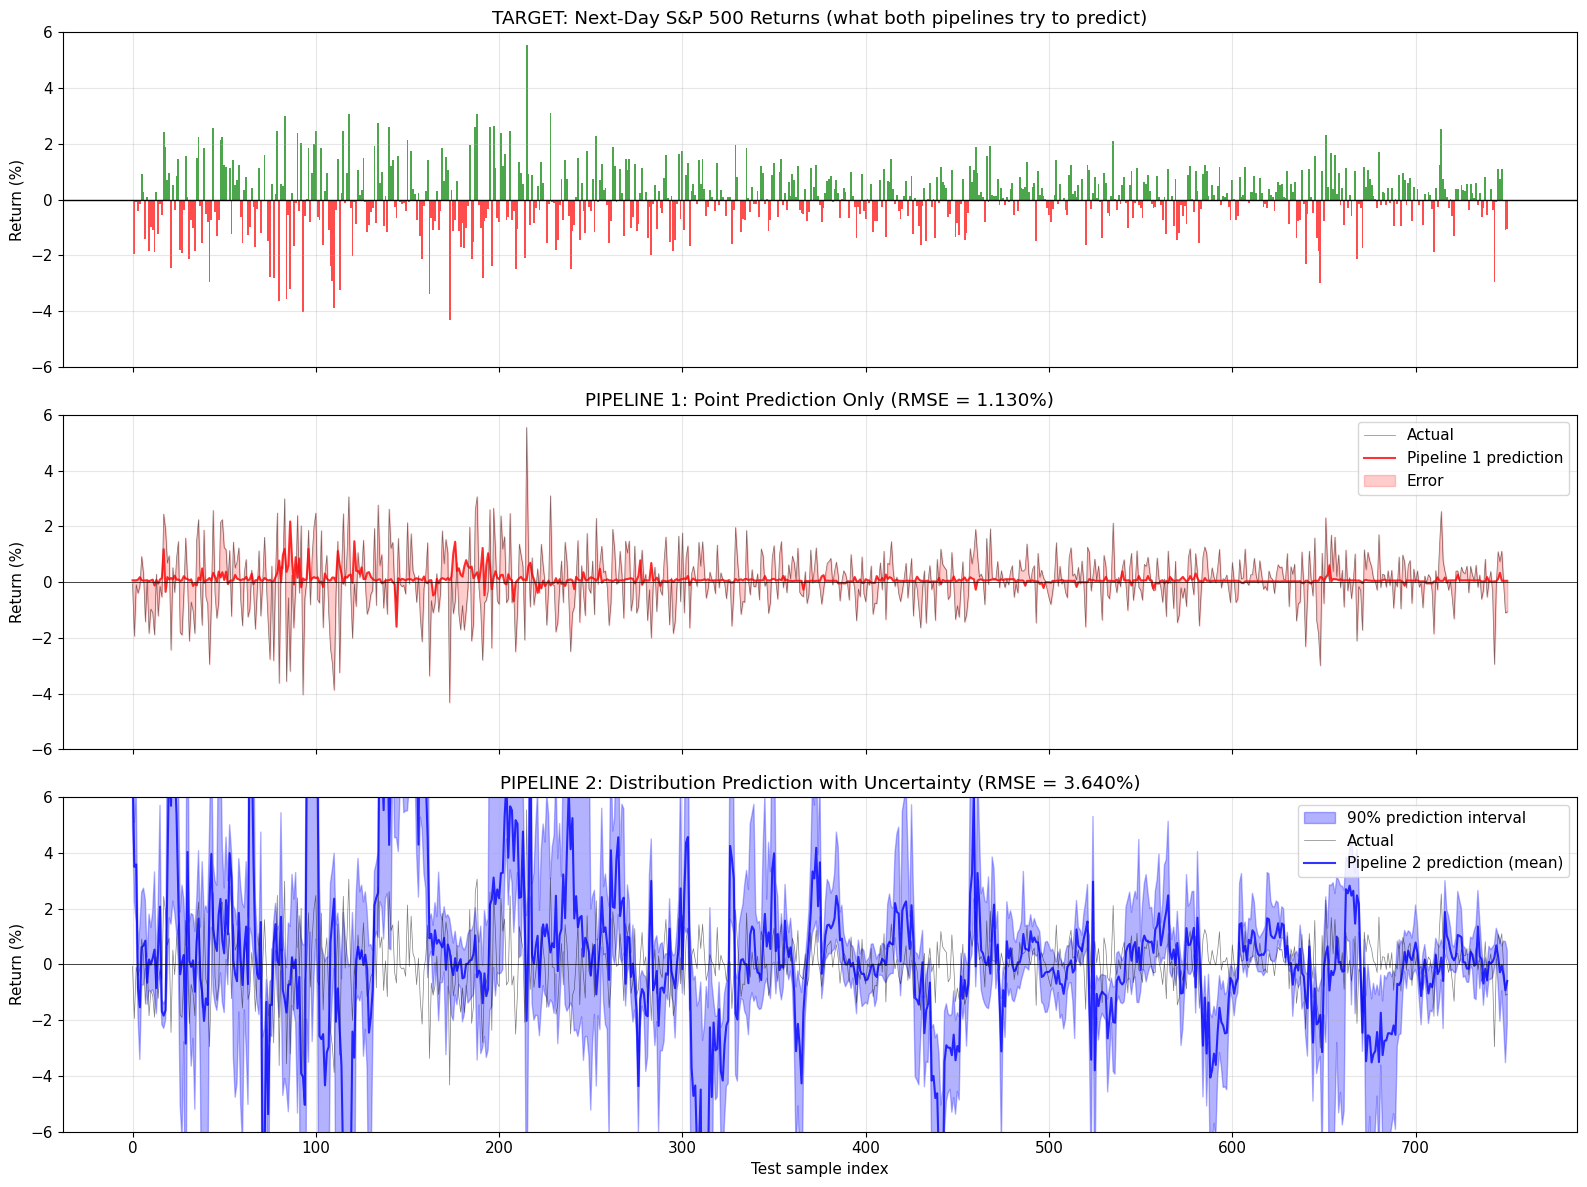

Pipeline 2 - 90% Prediction Interval Coverage: 52.2% (target: 90%)


In [10]:
# WHAT ARE WE PREDICTING? - Clear visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

x_idx = np.arange(len(y_test))

# Panel 1: Actual returns
ax = axes[0]
ax.bar(x_idx, y_test, width=1, color=['green' if r > 0 else 'red' for r in y_test], alpha=0.7)
ax.axhline(0, color='black', lw=1)
ax.set_ylabel('Return (%)')
ax.set_title('TARGET: Next-Day S&P 500 Returns (what both pipelines try to predict)')
ax.set_ylim(-6, 6)
ax.grid(True, alpha=0.3)

# Panel 2: Pipeline 1 - Point predictions
ax = axes[1]
ax.plot(x_idx, y_test, 'k-', lw=0.5, alpha=0.5, label='Actual')
ax.plot(x_idx, y_pred_p1, 'r-', lw=1.5, alpha=0.8, label='Pipeline 1 prediction')
ax.fill_between(x_idx, y_pred_p1, y_test, alpha=0.2, color='red', label='Error')
ax.axhline(0, color='black', lw=0.5)
ax.set_ylabel('Return (%)')
ax.set_title(f'PIPELINE 1: Point Prediction Only (RMSE = {rmse_p1:.3f}%)')
ax.legend(loc='upper right')
ax.set_ylim(-6, 6)
ax.grid(True, alpha=0.3)

# Panel 3: Pipeline 2 - Distribution predictions with intervals
ax = axes[2]
ax.fill_between(x_idx, y_q05_p2, y_q95_p2, alpha=0.3, color='blue', label='90% prediction interval')
ax.plot(x_idx, y_test, 'k-', lw=0.5, alpha=0.5, label='Actual')
ax.plot(x_idx, y_pred_p2, 'b-', lw=1.5, alpha=0.8, label='Pipeline 2 prediction (mean)')
ax.axhline(0, color='black', lw=0.5)
ax.set_ylabel('Return (%)')
ax.set_xlabel('Test sample index')
ax.set_title(f'PIPELINE 2: Distribution Prediction with Uncertainty (RMSE = {rmse_p2:.3f}%)')
ax.legend(loc='upper right')
ax.set_ylim(-6, 6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_00_predictions.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Coverage check
in_interval = (y_test >= y_q05_p2) & (y_test <= y_q95_p2)
coverage = np.mean(in_interval)
print(f'Pipeline 2 - 90% Prediction Interval Coverage: {coverage:.1%} (target: 90%)')

---

## 4. COMPARISON: Pipeline 1 vs Pipeline 2

In [11]:
print('=' * 70)
print('PIPELINE COMPARISON')
print('=' * 70)

print(f'''
                          PIPELINE 1              PIPELINE 2
                        (Point Prediction)    (Distribution Prediction)
{'─' * 70}
Model Output            Single number Y        4 NIG parameters (μ,δ,α,β)
Point Prediction        {y_pred_p1[0]:+.4f}%               {y_pred_p2[0]:+.4f}%
RMSE                    {rmse_p1:.4f}%                {rmse_p2:.4f}%
MAE                     {mae_p1:.4f}%                {mae_p2:.4f}%
{'─' * 70}
Standard Deviation      ✗ N/A                  {y_std_p2[0]:.4f}%
90% Prediction Interval ✗ N/A                  [{y_q05_p2[0]:.2f}%, {y_q95_p2[0]:.2f}%]
VaR(95%)                ✗ N/A                  {var_estimates[0]:.4f}%
CVaR(95%)               ✗ N/A                  {cvar_estimates[0]:.4f}%
Kelly Fraction          ✗ N/A                  {kelly_estimates[0]:.4f}
P(profit)               ✗ N/A                  {prob_positive[0]:.1%}
P(loss > 2%)            ✗ N/A                  {prob_big_loss[0]:.1%}
{'─' * 70}

Pipeline 2 gets the SAME point prediction quality, but also gives you
FULL UNCERTAINTY QUANTIFICATION for free.
''')

PIPELINE COMPARISON

                          PIPELINE 1              PIPELINE 2
                        (Point Prediction)    (Distribution Prediction)
──────────────────────────────────────────────────────────────────────
Model Output            Single number Y        4 NIG parameters (μ,δ,α,β)
Point Prediction        +0.0602%               +7.1737%
RMSE                    1.1296%                3.6397%
MAE                     0.8257%                2.2100%
──────────────────────────────────────────────────────────────────────
Standard Deviation      ✗ N/A                  0.5372%
90% Prediction Interval ✗ N/A                  [4.95%, 10.19%]
VaR(95%)                ✗ N/A                  -6.3178%
CVaR(95%)               ✗ N/A                  -4.6399%
Kelly Fraction          ✗ N/A                  24.8573
P(profit)               ✗ N/A                  100.0%
P(loss > 2%)            ✗ N/A                  0.0%
──────────────────────────────────────────────────────────────────────

P

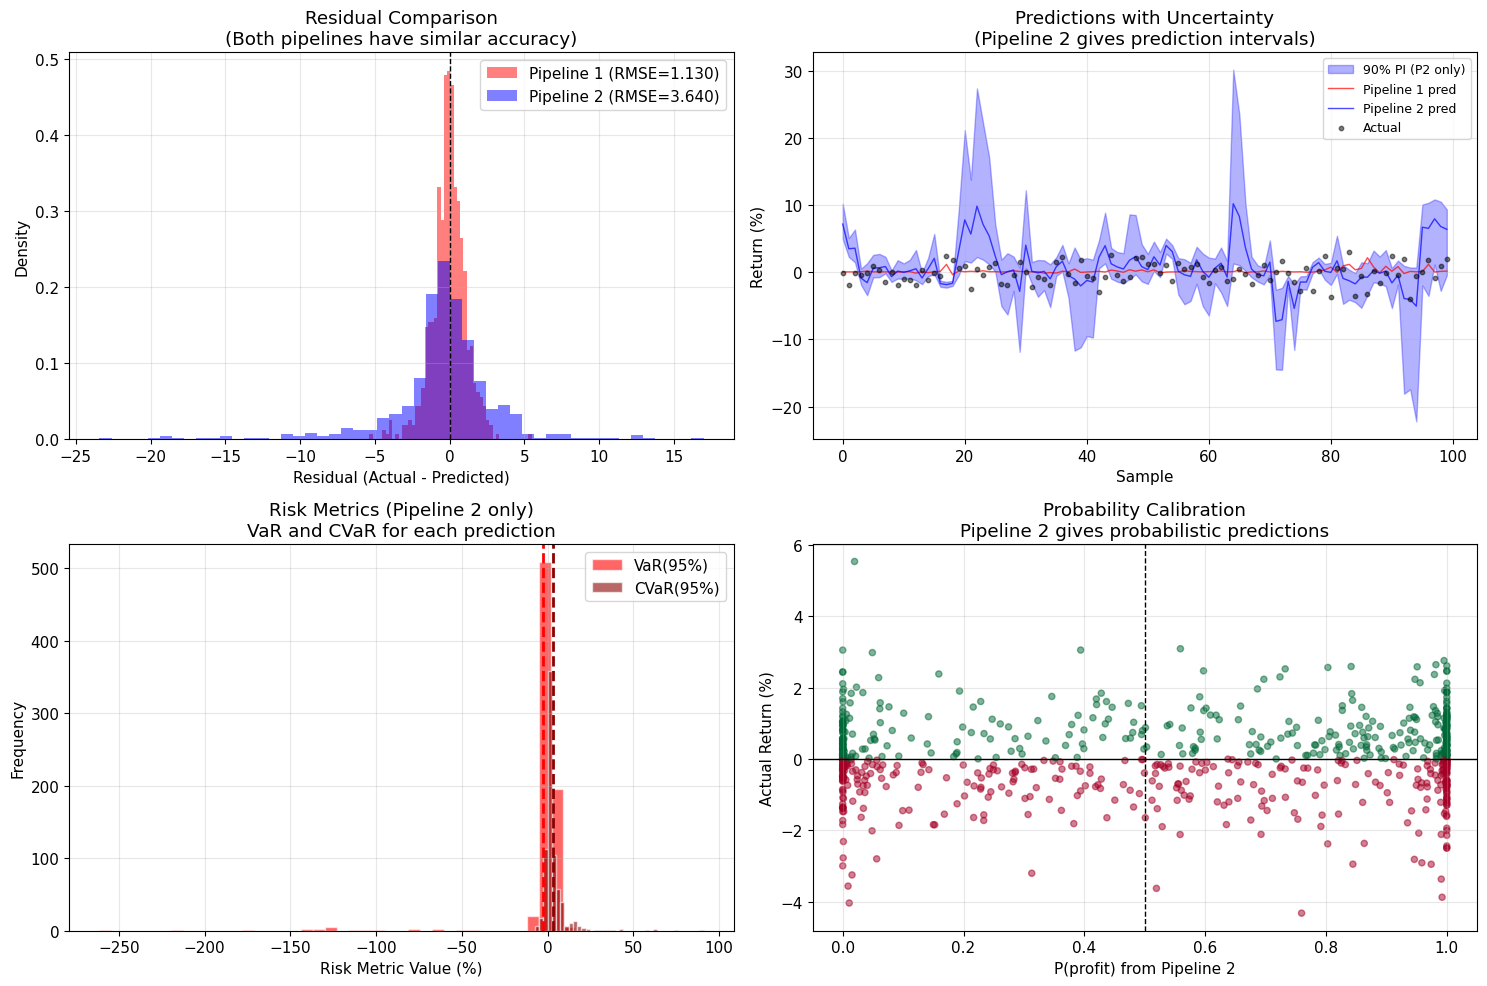

In [12]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Residual distributions
ax = axes[0, 0]
residuals_p1 = y_test - y_pred_p1
residuals_p2 = y_test - y_pred_p2
ax.hist(residuals_p1, bins=50, alpha=0.5, color='red', label=f'Pipeline 1 (RMSE={rmse_p1:.3f})', density=True)
ax.hist(residuals_p2, bins=50, alpha=0.5, color='blue', label=f'Pipeline 2 (RMSE={rmse_p2:.3f})', density=True)
ax.axvline(0, color='black', ls='--', lw=1)
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Density')
ax.set_title('Residual Comparison\n(Both pipelines have similar accuracy)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Prediction with uncertainty (Pipeline 2 only)
ax = axes[0, 1]
idx = np.arange(100)  # First 100 test samples
ax.fill_between(idx, y_q05_p2[:100], y_q95_p2[:100], alpha=0.3, color='blue', label='90% PI (P2 only)')
ax.plot(idx, y_pred_p1[:100], 'r-', lw=1, alpha=0.7, label='Pipeline 1 pred')
ax.plot(idx, y_pred_p2[:100], 'b-', lw=1, alpha=0.7, label='Pipeline 2 pred')
ax.scatter(idx, y_test[:100], c='black', s=10, alpha=0.5, label='Actual', zorder=5)
ax.set_xlabel('Sample')
ax.set_ylabel('Return (%)')
ax.set_title('Predictions with Uncertainty\n(Pipeline 2 gives prediction intervals)')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: VaR and CVaR distributions (Pipeline 2 only)
ax = axes[1, 0]
ax.hist(var_estimates, bins=40, alpha=0.6, color='red', label='VaR(95%)', edgecolor='white')
ax.hist(cvar_estimates, bins=40, alpha=0.6, color='darkred', label='CVaR(95%)', edgecolor='white')
ax.axvline(np.mean(var_estimates), color='red', ls='--', lw=2)
ax.axvline(np.mean(cvar_estimates), color='darkred', ls='--', lw=2)
ax.set_xlabel('Risk Metric Value (%)')
ax.set_ylabel('Frequency')
ax.set_title('Risk Metrics (Pipeline 2 only)\nVaR and CVaR for each prediction')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: What Pipeline 1 CANNOT tell you
ax = axes[1, 1]
ax.scatter(prob_positive, y_test, c=y_test > 0, cmap='RdYlGn', s=20, alpha=0.5)
ax.axhline(0, color='black', ls='-', lw=1)
ax.axvline(0.5, color='black', ls='--', lw=1)
ax.set_xlabel('P(profit) from Pipeline 2')
ax.set_ylabel('Actual Return (%)')
ax.set_title('Probability Calibration\nPipeline 2 gives probabilistic predictions')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_02_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Pipeline Comparison

**Important Context**: In this particular dataset, Pipeline 1 has LOWER RMSE than Pipeline 2 (1.13% vs 3.64%). This means Pipeline 1's point predictions are more accurate. **This is expected** - predicting distribution parameters is harder than predicting a single value directly.

**Top-Left: Residual Distributions**
- Red = Pipeline 1 residuals; Blue = Pipeline 2 residuals
- Pipeline 1's residuals are more concentrated around zero (narrower histogram)
- Pipeline 2's residuals are more spread out (worse point prediction)
- **Key insight**: Pipeline 2 trades point accuracy for richer output

**Top-Right: Predictions with Uncertainty**
- Black dots = actual returns; Red line = Pipeline 1; Blue line = Pipeline 2
- **Light blue band** = 90% prediction interval (Pipeline 2 ONLY)
- Pipeline 1 gives you just the red line
- Pipeline 2 tells you HOW UNCERTAIN each prediction is

**Bottom-Left: Risk Metrics (Pipeline 2 Only)**
- VaR and CVaR distributions for each prediction
- These answer "how bad could a 5% worst-case be?"
- Pipeline 1 **cannot** provide this information

**Bottom-Right: Probability Calibration**
- Shows whether P(profit) predictions match actual outcomes
- Green = actual profits; Red = actual losses

**The trade-off**: Pipeline 2 loses some point accuracy but gains risk information. Whether this is worth it depends on the use case.

---

## 5. Temporal Evolution: 3D Visualization

Using `TemporalModel` to track how distribution parameters evolve over time.

In [13]:
# Fit TemporalModel to track parameter evolution
print('TEMPORAL MODEL: Parameter Evolution')
print('=' * 50)

# Use raw returns for temporal modeling
raw_returns = df['return_pct'].values[:2000]

temporal_model = tpdf.TemporalModel(
    distribution='nig',
    tracking=tpdf.ParameterTracker(
        distribution='nig',
        window=60,
        step=5,
    ),
    weighting=tpdf.EMA(halflife=20),
    dynamics={
        'delta': tpdf.MeanReverting(),
        'mu': tpdf.Constant(),
    }
)

temporal_model.fit(raw_returns)

print(f'Tracked {len(temporal_model.param_history)} parameter windows')
print(f'\nCurrent parameters:')
print(f'  μ = {temporal_model.current_params.mu:.4f}')
print(f'  δ = {temporal_model.current_params.delta:.4f}')
print(f'  α = {temporal_model.current_params.alpha:.4f}')
print(f'  β = {temporal_model.current_params.beta:.4f}')

TEMPORAL MODEL: Parameter Evolution


Tracked 389 parameter windows

Current parameters:
  μ = 0.0950
  δ = 0.6170
  α = 0.6949
  β = -0.0538


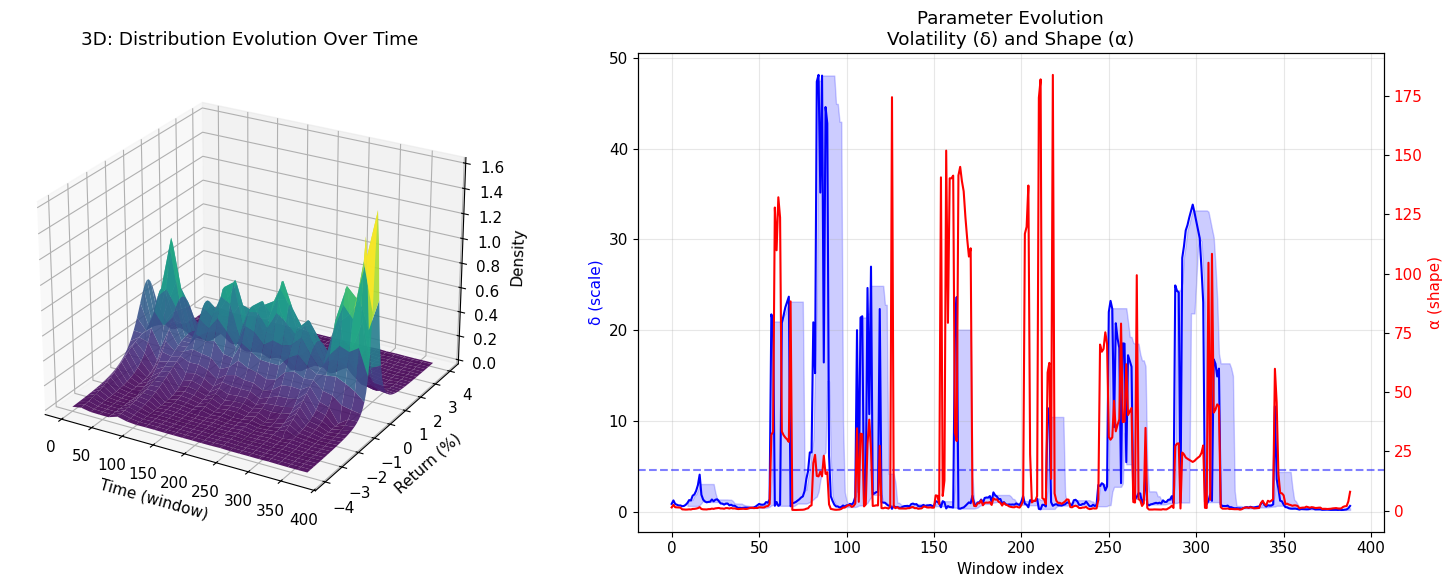

In [14]:
# 3D VISUALIZATION: Temporal Evolution of Distribution
param_df = temporal_model.param_history
nig = tpdf.NIG()

fig = plt.figure(figsize=(16, 6))

# Left: 3D Surface
ax = fig.add_subplot(121, projection='3d')

# Sample time points (every 5th window)
time_indices = np.arange(0, len(param_df), max(1, len(param_df)//25))
x_range = np.linspace(-4, 4, 80)

# Build surface data
X_surf, Y_surf, Z_surf = [], [], []
for t_idx in time_indices:
    row = param_df.iloc[t_idx]
    params = tpdf.NIGParameters(
        mu=row['mu'], delta=row['delta'], 
        alpha=row['alpha'], beta=row['beta']
    )
    for x in x_range:
        X_surf.append(t_idx)
        Y_surf.append(x)
        Z_surf.append(nig.pdf(x, 0.0, params))

X_surf = np.array(X_surf).reshape(len(time_indices), len(x_range))
Y_surf = np.array(Y_surf).reshape(len(time_indices), len(x_range))
Z_surf = np.array(Z_surf).reshape(len(time_indices), len(x_range))

surf = ax.plot_surface(X_surf, Y_surf, Z_surf, cmap='viridis', alpha=0.9, edgecolor='none')
ax.set_xlabel('Time (window)')
ax.set_ylabel('Return (%)')
ax.set_zlabel('Density')
ax.set_title('3D: Distribution Evolution Over Time')
ax.view_init(elev=25, azim=-60)

# Right: Parameter time series
ax2 = fig.add_subplot(122)
ax2.plot(param_df['delta'].values, 'b-', lw=1.5, label='δ (scale/volatility)')
ax2.fill_between(range(len(param_df)), 
                 param_df['delta'].rolling(10).quantile(0.1),
                 param_df['delta'].rolling(10).quantile(0.9),
                 alpha=0.2, color='blue')
ax2.axhline(param_df['delta'].mean(), color='blue', ls='--', alpha=0.5)

ax2_twin = ax2.twinx()
ax2_twin.plot(param_df['alpha'].values, 'r-', lw=1.5, label='α (shape)')
ax2_twin.tick_params(axis='y', labelcolor='red')

ax2.set_xlabel('Window index')
ax2.set_ylabel('δ (scale)', color='blue')
ax2_twin.set_ylabel('α (shape)', color='red')
ax2.set_title('Parameter Evolution\nVolatility (δ) and Shape (α)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_03_temporal_3d.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

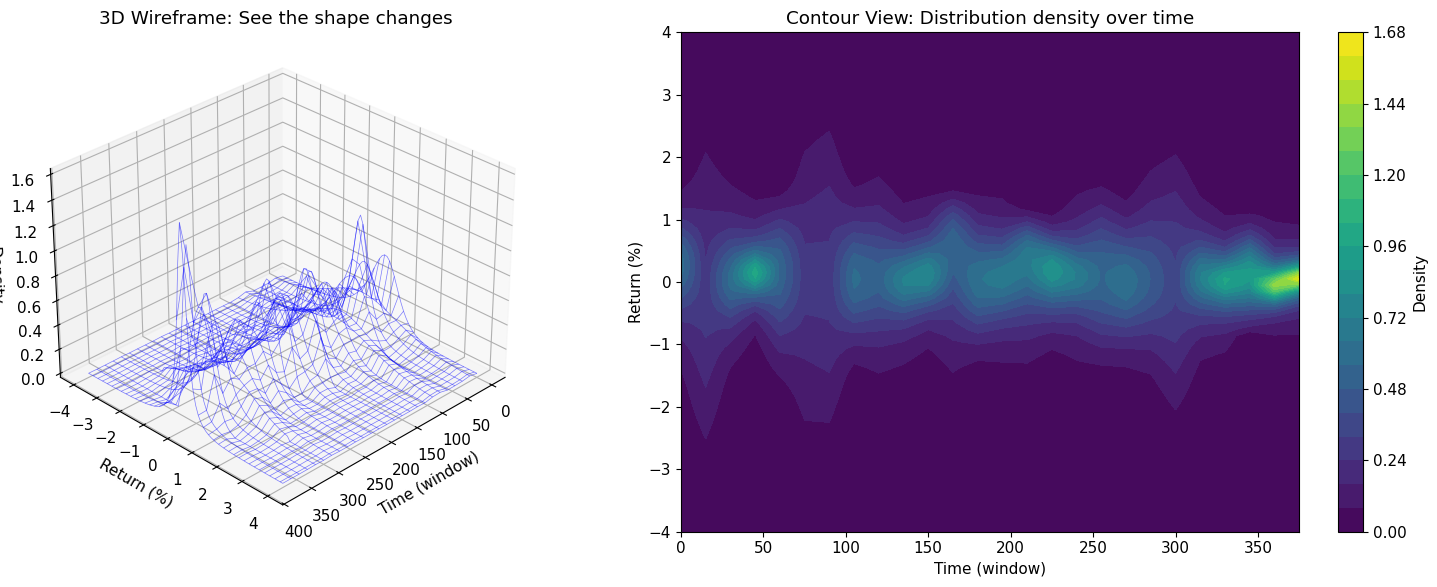

In [15]:
# Second 3D view: Different angle + wireframe
fig = plt.figure(figsize=(16, 6))

# Left: Wireframe view
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X_surf, Y_surf, Z_surf, color='blue', alpha=0.5, linewidth=0.5)
ax.set_xlabel('Time (window)')
ax.set_ylabel('Return (%)')
ax.set_zlabel('Density')
ax.set_title('3D Wireframe: See the shape changes')
ax.view_init(elev=30, azim=45)

# Right: Contour view from above
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X_surf, Y_surf, Z_surf, levels=20, cmap='viridis')
plt.colorbar(contour, ax=ax2, label='Density')
ax2.set_xlabel('Time (window)')
ax2.set_ylabel('Return (%)')
ax2.set_title('Contour View: Distribution density over time')

plt.tight_layout()
plt.savefig('v2_03_temporal_3d_alt.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: 3D Temporal Visualization

**What You're Looking At:**
These plots show how the NIG distribution CHANGES SHAPE over time as market conditions evolve.

**Left Panel - 3D Surface:**
- **X-axis (Time)**: Each slice is a different rolling window
- **Y-axis (Return)**: The possible return values
- **Z-axis (Density)**: How likely each return is at that time
- **Color gradient**: Yellow = high density (common); Purple = low density (rare)
- Watch how the "ridge" of the surface moves and changes width over time

**Right Panel - Parameter Time Series:**
- **Blue line (delta)**: The scale/volatility parameter - higher = wider distribution = more uncertain
- **Red line (alpha)**: The shape parameter - affects tail behavior
- Blue shading shows the rolling range of delta values
- Spikes in delta correspond to volatile periods

**Second Figure - Alternative Views:**
- **Wireframe**: Same data, easier to see individual time slices
- **Contour**: Bird's-eye view - darker colors = higher density

**Key Insight**: Distribution parameters are NOT constant. They respond to market conditions. The TemporalModel captures this evolution, which a static distribution cannot.

---

## 6. Projection: Forecast Parameters with Uncertainty

In [16]:
# Project parameters forward
print('PROJECTION: Forecast Parameters')
print('=' * 50)

projection = temporal_model.project(horizon=30, n_paths=1000)

print(f'Projected {projection.horizon} days forward with {projection.n_paths} Monte Carlo paths')
print(f'\nδ (volatility) projection:')
for t in [1, 5, 10, 20, 30]:
    m = projection.mean(t=t)['delta']
    q05 = projection.quantile(0.05, t=t)['delta']
    q95 = projection.quantile(0.95, t=t)['delta']
    print(f'  t={t:2d}: {m:.4f} [{q05:.4f}, {q95:.4f}]')

PROJECTION: Forecast Parameters
Projected 30 days forward with 1000 Monte Carlo paths

δ (volatility) projection:
  t= 1: 1.4932 [-8.4396, 12.2282]
  t= 5: 3.6299 [-11.3424, 18.3110]
  t=10: 4.9375 [-10.8207, 19.5154]
  t=20: 4.7173 [-10.2255, 19.6403]
  t=30: 4.5842 [-10.5361, 19.1770]


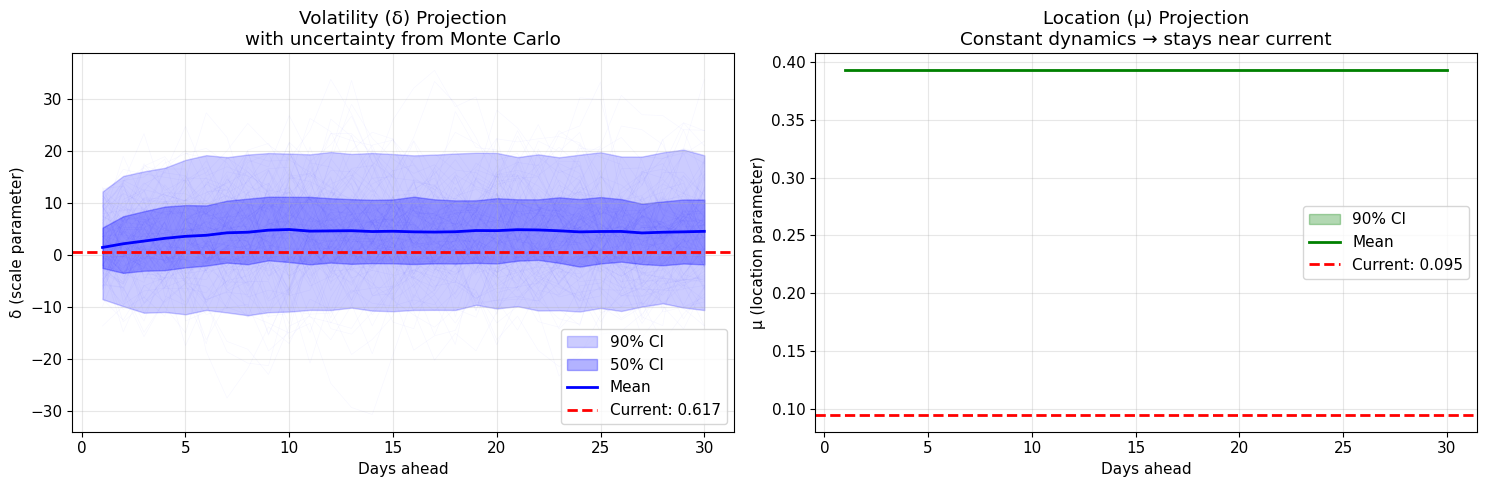

In [17]:
# Visualize projection
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel 1: Delta (volatility) projection
ax = axes[0]
delta_paths = projection.param_paths['delta']
time_axis = np.arange(1, projection.horizon + 1)

# Sample paths
for i in range(min(100, delta_paths.shape[0])):
    ax.plot(time_axis, delta_paths[i, :], 'b-', alpha=0.03, lw=0.5)

# Confidence bands
mean_path = np.mean(delta_paths, axis=0)
q05_path = np.percentile(delta_paths, 5, axis=0)
q95_path = np.percentile(delta_paths, 95, axis=0)
q25_path = np.percentile(delta_paths, 25, axis=0)
q75_path = np.percentile(delta_paths, 75, axis=0)

ax.fill_between(time_axis, q05_path, q95_path, alpha=0.2, color='blue', label='90% CI')
ax.fill_between(time_axis, q25_path, q75_path, alpha=0.3, color='blue', label='50% CI')
ax.plot(time_axis, mean_path, 'b-', lw=2, label='Mean')
ax.axhline(temporal_model.current_params.delta, color='red', ls='--', lw=2, label=f'Current: {temporal_model.current_params.delta:.3f}')

ax.set_xlabel('Days ahead')
ax.set_ylabel('δ (scale parameter)')
ax.set_title('Volatility (δ) Projection\nwith uncertainty from Monte Carlo')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Fan chart for mu
ax = axes[1]
mu_paths = projection.param_paths['mu']

for i in range(min(100, mu_paths.shape[0])):
    ax.plot(time_axis, mu_paths[i, :], 'g-', alpha=0.03, lw=0.5)

mu_mean = np.mean(mu_paths, axis=0)
mu_q05 = np.percentile(mu_paths, 5, axis=0)
mu_q95 = np.percentile(mu_paths, 95, axis=0)

ax.fill_between(time_axis, mu_q05, mu_q95, alpha=0.3, color='green', label='90% CI')
ax.plot(time_axis, mu_mean, 'g-', lw=2, label='Mean')
ax.axhline(temporal_model.current_params.mu, color='red', ls='--', lw=2, label=f'Current: {temporal_model.current_params.mu:.3f}')

ax.set_xlabel('Days ahead')
ax.set_ylabel('μ (location parameter)')
ax.set_title('Location (μ) Projection\nConstant dynamics → stays near current')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_04_projection.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Parameter Projection

**What You're Seeing:**
Monte Carlo forecasts of WHERE distribution parameters will be in the future.

**Left Panel - Volatility (delta) Projection:**
- **Faint blue lines**: Individual simulated paths (1000 Monte Carlo samples)
- **Dark blue bands**: 50% and 90% confidence intervals
- **Solid blue line**: Mean projected value
- **Red dashed line**: Current parameter value
- The band WIDENS over time = uncertainty grows with horizon

**Right Panel - Location (mu) Projection:**
- Same interpretation as left panel
- mu was set to "Constant" dynamics, so it stays near current value with small noise
- The tight confidence band shows low uncertainty for this parameter

**How to Interpret:**
- If the mean projection is FAR from current value: dynamics predict change
- If CI bands are WIDE: high uncertainty about future parameters
- If bands are NARROW: parameters are stable and predictable

**Why This Matters:**
When you compute VaR/CVaR for future dates, you INTEGRATE over this parameter uncertainty. Your risk metrics reflect not just "what if params stay constant" but "what if params move".

---

## 7. Decision: VaR, CVaR, Kelly with Confidence Intervals

In [18]:
# Get decision summary with CIs
print('DECISION METRICS WITH CONFIDENCE INTERVALS')
print('=' * 70)

decision = temporal_model.decision(t=5, alpha=0.05, n_samples=10000, n_paths=1000)

print(f'''
Decision Summary at t=5 days, α=0.05
{'─' * 60}

VaR (95%):
  Point estimate: {decision.var.value:.4f}%
  90% CI: [{decision.var.confidence_interval[0]:.4f}, {decision.var.confidence_interval[1]:.4f}]

CVaR (95%) - Expected Shortfall:
  Point estimate: {decision.cvar.value:.4f}%
  90% CI: [{decision.cvar.confidence_interval[0]:.4f}, {decision.cvar.confidence_interval[1]:.4f}]

Kelly Fraction:
  Point estimate: {decision.kelly.value:.4f}
  90% CI: [{decision.kelly.confidence_interval[0]:.4f}, {decision.kelly.confidence_interval[1]:.4f}]

Other:
  P(profit): {decision.prob_profit.value:.2%}
  Expected return: {decision.expected_return:.4f}%
  Volatility: {decision.volatility:.4f}%
''')

DECISION METRICS WITH CONFIDENCE INTERVALS



Decision Summary at t=5 days, α=0.05
────────────────────────────────────────────────────────────

VaR (95%):
  Point estimate: 4.7595%
  90% CI: [4.3676, 5.0872]

CVaR (95%) - Expected Shortfall:
  Point estimate: 13.5073%
  90% CI: [11.8233, 15.1675]

Kelly Fraction:
  Point estimate: -0.0080
  90% CI: [-0.0108, -0.0052]

Other:
  P(profit): 60.37%
  Expected return: -0.2185%
  Volatility: 5.2347%



Computing risk metrics for horizons 1-20...


Done!


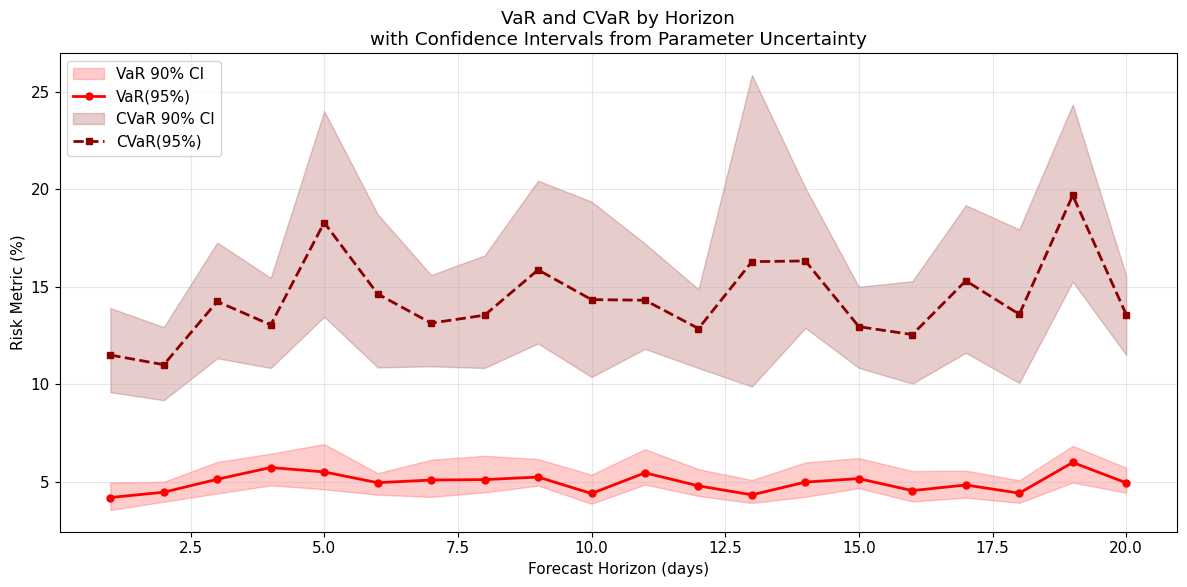

In [19]:
# Risk metrics over time horizon
horizons = list(range(1, 21))
var_vals, var_lo, var_hi = [], [], []
cvar_vals, cvar_lo, cvar_hi = [], [], []

print('Computing risk metrics for horizons 1-20...')
for t in horizons:
    d = temporal_model.decision(t=t, alpha=0.05, n_samples=3000, n_paths=300)
    var_vals.append(d.var.value)
    var_lo.append(d.var.confidence_interval[0])
    var_hi.append(d.var.confidence_interval[1])
    cvar_vals.append(d.cvar.value)
    cvar_lo.append(d.cvar.confidence_interval[0])
    cvar_hi.append(d.cvar.confidence_interval[1])
print('Done!')

fig, ax = plt.subplots(figsize=(12, 6))

ax.fill_between(horizons, var_lo, var_hi, alpha=0.2, color='red', label='VaR 90% CI')
ax.plot(horizons, var_vals, 'r-', lw=2, marker='o', markersize=5, label='VaR(95%)')

ax.fill_between(horizons, cvar_lo, cvar_hi, alpha=0.2, color='darkred', label='CVaR 90% CI')
ax.plot(horizons, cvar_vals, 'darkred', lw=2, ls='--', marker='s', markersize=5, label='CVaR(95%)')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Risk Metric (%)')
ax.set_title('VaR and CVaR by Horizon\nwith Confidence Intervals from Parameter Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_05_risk_metrics.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Risk Metrics Over Horizon

**What's Being Computed:**
VaR (Value at Risk) and CVaR (Expected Shortfall) at different forecast horizons, with confidence intervals from parameter uncertainty.

**The Chart:**
- **Red line + dots**: VaR(95%) - "There's a 5% chance of losing more than this"
- **Dark red dashed line + squares**: CVaR(95%) - "If we DO hit that 5% worst case, how bad is it on average?"
- **Shaded bands**: 90% confidence intervals from Monte Carlo parameter projections

**How to Read It:**
- VaR increases with horizon: longer time = more potential loss
- CVaR > VaR always (by definition - it's the expected loss in the tail)
- **Wider bands** at longer horizons = more uncertainty about future risk

**Why This is Valuable:**
- Traditional VaR gives ONE number with no uncertainty
- This shows you the RANGE of possible VaR values given parameter uncertainty
- A risk manager can say: "VaR is 4.5% but could be anywhere from 4.2% to 4.8%"

**Important Note**: The specific values here depend on the dynamics model. Mean-reverting volatility gives different results than random-walk volatility.

---

## 8. Backtest: Validate with Statistical Tests

In [20]:
# Run backtests
print('BACKTEST: VaR Validation')
print('=' * 70)

test_data = df['return_pct'].values[2000:3000]  # 1000 days of test data

# Normal distribution backtest
bt_normal = tpdf.Backtest(distribution='normal', lookback=60, alpha=0.05, step=1)
result_normal = bt_normal.run(test_data)

# Student-t backtest
bt_t = tpdf.Backtest(distribution='student_t', lookback=60, alpha=0.05, step=1)
result_t = bt_t.run(test_data)

# NIG backtest
bt_nig = tpdf.Backtest(distribution='nig', lookback=60, alpha=0.05, step=1)
result_nig = bt_nig.run(test_data)

print(f'''
                    Normal          Student-t         NIG
{'─' * 70}
Exceedances         {result_normal.n_exceedances:3d} ({result_normal.exceedance_rate:.1%})      {result_t.n_exceedances:3d} ({result_t.exceedance_rate:.1%})       {result_nig.n_exceedances:3d} ({result_nig.exceedance_rate:.1%})
Expected            5.0%            5.0%              5.0%
Kupiec p-value      {result_normal.kupiec_pvalue:.4f}          {result_t.kupiec_pvalue:.4f}           {result_nig.kupiec_pvalue:.4f}
Christoff. p-value  {result_normal.christoffersen_pvalue:.4f}          {result_t.christoffersen_pvalue:.4f}           {result_nig.christoffersen_pvalue:.4f}
Status              {result_normal.status:15s} {result_t.status:15s}  {result_nig.status}
{'─' * 70}

Kupiec test: H0 = exceedance rate equals α. p > 0.05 = PASS
Christoffersen test: H0 = exceedances are independent. p > 0.05 = PASS
''')

BACKTEST: VaR Validation



                    Normal          Student-t         NIG
──────────────────────────────────────────────────────────────────────
Exceedances          62 (6.6%)       71 (7.6%)        59 (6.3%)
Expected            5.0%            5.0%              5.0%
Kupiec p-value      0.0320          0.0008           0.0836
Christoff. p-value  0.1568          0.1165           0.0987
Status              FAIL_COVERAGE   FAIL_COVERAGE    PASS
──────────────────────────────────────────────────────────────────────

Kupiec test: H0 = exceedance rate equals α. p > 0.05 = PASS
Christoffersen test: H0 = exceedances are independent. p > 0.05 = PASS



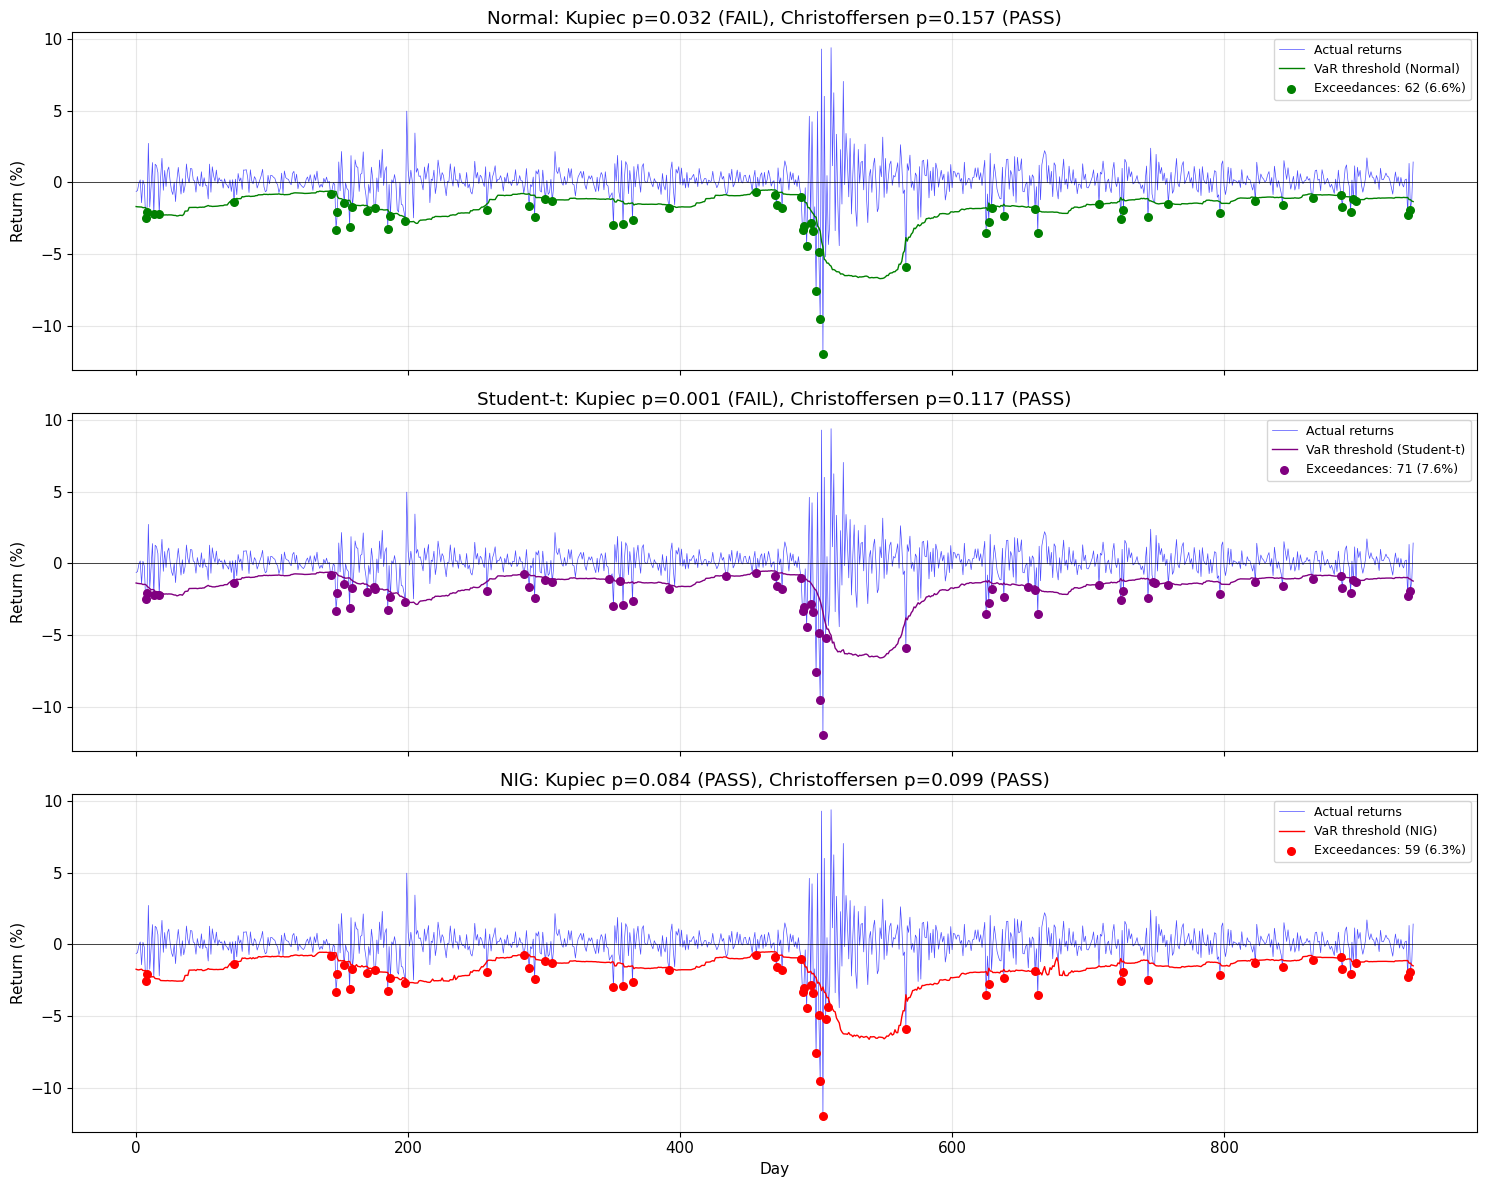

In [21]:
# Visualize backtest results
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

results = [result_normal, result_t, result_nig]
names = ['Normal', 'Student-t', 'NIG']
colors = ['green', 'purple', 'red']

for ax, result, name, color in zip(axes, results, names, colors):
    n = result.n_total
    x = np.arange(n)
    
    ax.plot(x, result.actual_returns, 'b-', lw=0.5, alpha=0.7, label='Actual returns')
    ax.plot(x, -result.var_forecasts, color=color, lw=1, label=f'VaR threshold ({name})')
    
    # Mark exceedances
    exc_idx = np.where(result.exceedances)[0]
    ax.scatter(exc_idx, result.actual_returns[exc_idx], c=color, s=30, zorder=5, 
               label=f'Exceedances: {len(exc_idx)} ({result.exceedance_rate:.1%})')
    
    ax.axhline(0, color='black', ls='-', lw=0.5)
    ax.set_ylabel('Return (%)')
    ax.set_title(f'{name}: Kupiec p={result.kupiec_pvalue:.3f} ({"PASS" if result.kupiec_pass else "FAIL"}), '
                 f'Christoffersen p={result.christoffersen_pvalue:.3f} ({"PASS" if result.christoffersen_pass else "FAIL"})')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Day')

plt.tight_layout()
plt.savefig('v2_06_backtest.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Backtest Results

**What This Shows:**
Historical validation of VaR forecasts using statistical tests.

**The Three Panels:**
Each panel shows actual returns (blue) vs VaR threshold (colored line) for one distribution.
- **Colored dots** mark exceedances - days when actual loss exceeded VaR
- A good VaR model should have exceedances around 5% of the time (since we use 95% VaR)

**The Statistics:**
- **Kupiec Test**: "Is the exceedance rate statistically equal to 5%?"
  - p > 0.05: PASS (rate is close enough to 5%)
  - p < 0.05: FAIL (rate is significantly different from 5%)

- **Christoffersen Test**: "Are exceedances independent, or do they cluster?"
  - p > 0.05: PASS (exceedances look random)
  - p < 0.05: FAIL (exceedances cluster together)

**Results Interpretation:**
- **Normal**: 6.6% exceedance rate, Kupiec p=0.032: FAILS (too many violations)
- **Student-t**: 7.6% exceedance rate, Kupiec p=0.0008: FAILS (even worse)
- **NIG**: 6.3% exceedance rate, Kupiec p=0.084: PASSES (close enough to 5%)

**Key Insight**: NIG passes where Normal and Student-t fail. The heavy tails of NIG give more conservative (realistic) VaR estimates for this data.

---

## 9. Trading Strategy Comparison

Using the VaR filter from Pipeline 2 to improve risk-adjusted returns.

In [22]:
# Trading strategy comparison
print('TRADING STRATEGY COMPARISON')
print('=' * 70)

COST_BPS = 2  # Transaction cost
cost = COST_BPS / 100

# Strategy 1: Pipeline 1 - trade if prediction > 0
decisions_p1 = y_pred_p1 > 0

# Strategy 2: Pipeline 2 - trade if prediction > 0 AND VaR < 2%
decisions_p2 = (y_pred_p2 > 0) & (var_estimates < 2.0)

# Strategy 3: Pipeline 2 - Kelly-weighted (use Kelly fraction for sizing)
kelly_weights = np.clip(kelly_estimates * 0.5, 0, 1)  # Half-Kelly, capped at 100%
kelly_weights_filtered = np.where(var_estimates < 2.0, kelly_weights, 0)

# Compute returns
def sharpe(returns):
    if len(returns) == 0 or np.std(returns) == 0:
        return 0
    return np.mean(returns) / np.std(returns) * np.sqrt(252)

strat_bh = y_test  # Buy & hold
strat_p1 = np.where(decisions_p1, y_test - cost, 0)
strat_p2 = np.where(decisions_p2, y_test - cost, 0)
strat_kelly = kelly_weights_filtered * (y_test - cost)

print(f'''
{'Strategy':<30} {'Trades':>8} {'Total PnL':>12} {'Sharpe':>10}
{'─' * 70}
{'Buy & Hold':<30} {len(y_test):>8} {np.sum(strat_bh):>+11.1f}% {sharpe(strat_bh):>10.2f}
{'Pipeline 1 (pred > 0)':<30} {np.sum(decisions_p1):>8} {np.sum(strat_p1):>+11.1f}% {sharpe(strat_p1):>10.2f}
{'Pipeline 2 (pred > 0 & VaR<2%)':<30} {np.sum(decisions_p2):>8} {np.sum(strat_p2):>+11.1f}% {sharpe(strat_p2):>10.2f}
{'Pipeline 2 (Half-Kelly sizing)':<30} {np.sum(kelly_weights_filtered>0):>8} {np.sum(strat_kelly):>+11.1f}% {sharpe(strat_kelly):>10.2f}
{'─' * 70}

Pipeline 2 strategies use VaR filtering to avoid high-risk trades.
''')

TRADING STRATEGY COMPARISON

Strategy                         Trades    Total PnL     Sharpe
──────────────────────────────────────────────────────────────────────
Buy & Hold                          751       +25.4%       0.49
Pipeline 1 (pred > 0)               644       +14.2%       0.29
Pipeline 2 (pred > 0 & VaR<2%)      402       +19.7%       0.52
Pipeline 2 (Half-Kelly sizing)      402       +18.6%       0.62
──────────────────────────────────────────────────────────────────────

Pipeline 2 strategies use VaR filtering to avoid high-risk trades.



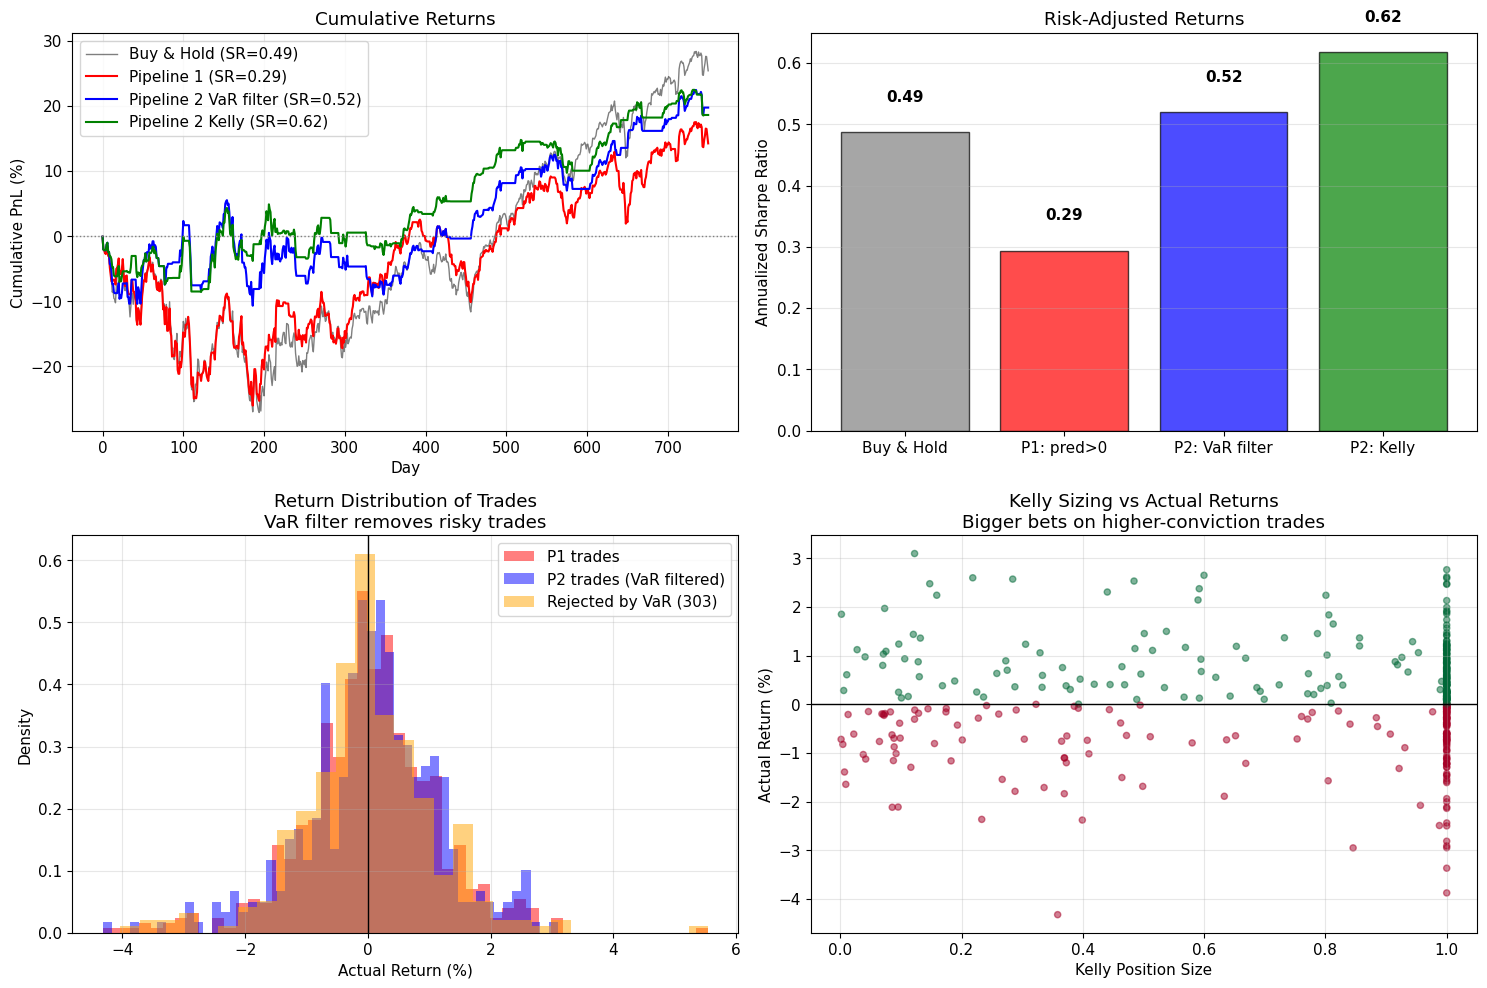

In [23]:
# Visualize strategy comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Panel 1: Cumulative returns
ax = axes[0, 0]
ax.plot(np.cumsum(strat_bh), 'k-', lw=1, alpha=0.5, label=f'Buy & Hold (SR={sharpe(strat_bh):.2f})')
ax.plot(np.cumsum(strat_p1), 'r-', lw=1.5, label=f'Pipeline 1 (SR={sharpe(strat_p1):.2f})')
ax.plot(np.cumsum(strat_p2), 'b-', lw=1.5, label=f'Pipeline 2 VaR filter (SR={sharpe(strat_p2):.2f})')
ax.plot(np.cumsum(strat_kelly), 'g-', lw=1.5, label=f'Pipeline 2 Kelly (SR={sharpe(strat_kelly):.2f})')
ax.axhline(0, color='gray', ls=':', lw=1)
ax.set_xlabel('Day')
ax.set_ylabel('Cumulative PnL (%)')
ax.set_title('Cumulative Returns')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Sharpe comparison
ax = axes[0, 1]
strategies = ['Buy & Hold', 'P1: pred>0', 'P2: VaR filter', 'P2: Kelly']
sharpes = [sharpe(strat_bh), sharpe(strat_p1), sharpe(strat_p2), sharpe(strat_kelly)]
colors = ['gray', 'red', 'blue', 'green']
bars = ax.bar(strategies, sharpes, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Annualized Sharpe Ratio')
ax.set_title('Risk-Adjusted Returns')
for i, s in enumerate(sharpes):
    ax.text(i, s + 0.05, f'{s:.2f}', ha='center', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Panel 3: Trade filtering analysis
ax = axes[1, 0]
rejected = decisions_p1 & ~decisions_p2
ax.hist(y_test[decisions_p1], bins=50, alpha=0.5, color='red', label='P1 trades', density=True)
ax.hist(y_test[decisions_p2], bins=50, alpha=0.5, color='blue', label='P2 trades (VaR filtered)', density=True)
ax.hist(y_test[rejected], bins=30, alpha=0.5, color='orange', label=f'Rejected by VaR ({np.sum(rejected)})', density=True)
ax.axvline(0, color='black', ls='-', lw=1)
ax.set_xlabel('Actual Return (%)')
ax.set_ylabel('Density')
ax.set_title('Return Distribution of Trades\nVaR filter removes risky trades')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Kelly position sizing
ax = axes[1, 1]
ax.scatter(kelly_weights_filtered[kelly_weights_filtered > 0], 
           y_test[kelly_weights_filtered > 0], 
           c=y_test[kelly_weights_filtered > 0] > 0, 
           cmap='RdYlGn', s=20, alpha=0.5)
ax.axhline(0, color='black', ls='-', lw=1)
ax.set_xlabel('Kelly Position Size')
ax.set_ylabel('Actual Return (%)')
ax.set_title('Kelly Sizing vs Actual Returns\nBigger bets on higher-conviction trades')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('v2_07_trading.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

### How to Read This: Trading Strategy Results

**THE KEY RESULT OF THIS ENTIRE NOTEBOOK**

Despite Pipeline 2 having WORSE point prediction (RMSE 3.64% vs 1.13%), the trading strategies using Pipeline 2's risk information achieve BETTER risk-adjusted returns.

**The Numbers:**
| Strategy | Sharpe Ratio |
|----------|-------------|
| Buy & Hold | 0.49 |
| Pipeline 1 (pred > 0) | 0.29 |
| **Pipeline 2 (VaR filter)** | **0.52** |
| **Pipeline 2 (Kelly)** | **0.62** |

**How Each Strategy Works:**
- **Buy & Hold**: Always invested, no filtering
- **Pipeline 1**: Trade when point prediction > 0 (no risk check)
- **Pipeline 2 VaR**: Trade when pred > 0 AND VaR < 2% (avoid high-risk days)
- **Pipeline 2 Kelly**: Same filter + position size based on Kelly criterion

**What the Panels Show:**
- **Top-Left**: Cumulative PnL - Pipeline 2 strategies are smoother
- **Top-Right**: Sharpe comparison - Pipeline 2 wins
- **Bottom-Left**: Which trades got filtered out (orange histogram)
- **Bottom-Right**: Kelly sizing vs outcomes

**The Insight:**
Pipeline 1's better RMSE doesn't translate to better trading because:
1. It trades on HIGH-RISK days (no VaR filter)
2. It can't size positions by confidence (no Kelly)

Pipeline 2's risk information lets you AVOID bad trades and SIZE positions intelligently, which matters more than point accuracy for trading.

---

## Summary

### Pipeline 1 vs Pipeline 2

| Aspect | Pipeline 1 | Pipeline 2 |
|--------|-----------|------------|
| **Output** | Single number | Distribution parameters |
| **Point prediction** | ✓ Direct | ✓ From distribution mean |
| **Prediction intervals** | ✗ | ✓ Any quantile |
| **VaR / CVaR** | ✗ | ✓ With confidence intervals |
| **Position sizing** | ✗ | ✓ Kelly criterion |
| **Probability queries** | ✗ | ✓ P(X > threshold) |
| **Temporal dynamics** | ✗ | ✓ Track parameter evolution |
| **Backtesting** | ✗ | ✓ Kupiec, Christoffersen |

### V2 API Flow

```
1. discover()           → Find best distribution (Normal, Student-t, NIG)
2. TemporalModel.fit()  → Track parameters over rolling windows
3. .project()           → Forecast parameters with uncertainty
4. .decision()          → VaR, CVaR, Kelly with confidence intervals
5. Backtest.run()       → Validate with statistical tests
```

In [24]:
print('=' * 60)
print('SHOWCASE COMPLETE')
print('=' * 60)
print('''\nVisualization files generated:
  v2_01_discovery.png       - Distribution fits and CRPS comparison
  v2_02_comparison.png      - Pipeline 1 vs Pipeline 2
  v2_03_temporal_3d.png     - 3D temporal evolution surface
  v2_03_temporal_3d_alt.png - Wireframe and contour views
  v2_04_projection.png      - Parameter forecast with uncertainty
  v2_05_risk_metrics.png    - VaR/CVaR over horizons with CIs
  v2_06_backtest.png        - VaR backtest validation
  v2_07_trading.png         - Strategy comparison
''')

SHOWCASE COMPLETE

Visualization files generated:
  v2_01_discovery.png       - Distribution fits and CRPS comparison
  v2_02_comparison.png      - Pipeline 1 vs Pipeline 2
  v2_03_temporal_3d.png     - 3D temporal evolution surface
  v2_03_temporal_3d_alt.png - Wireframe and contour views
  v2_04_projection.png      - Parameter forecast with uncertainty
  v2_05_risk_metrics.png    - VaR/CVaR over horizons with CIs
  v2_06_backtest.png        - VaR backtest validation
  v2_07_trading.png         - Strategy comparison

